In [ ]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.stats import poisson, nbinom, bernoulli
from scipy.spatial.distance import pdist, squareform
from typing import Dict, List, Tuple
from tqdm import tqdm
from numba import jit
from concurrent.futures import ThreadPoolExecutor
import logging

logging.basicConfig(level=logging.INFO)

class OptimizedSpatialExpressionSimulator:
    def __init__(
        self,
        coords: np.ndarray,
        model_params: Dict,
        target_moran: pd.DataFrame,
        gene_pairs: List[Tuple[str, str]],
        target_correlations: np.ndarray,
    ):
        self.coords = coords
        self.n_spots = len(coords)
        self.genes = list(target_moran.index)
        
        # 重新组织model_params确保基因对应关系正确
        self.model_params = self._reorganize_model_params(model_params)
        
        self.target_moran = target_moran
        self.gene_pairs = gene_pairs
        self.target_correlations = target_correlations
        self.weights = self._calculate_weights().astype(np.float64)
        self.moran_weights = self._calculate_moran_weights().astype(np.float64)
        
        self.sorted_genes = self.target_moran.sort_values('moran_I', ascending=False).index.tolist()
        
        # 创建基因对的字典
        self.gene_pair_dict = {}
        for (g1, g2), corr in zip(gene_pairs, target_correlations):
            if g1 in self.genes and g2 in self.genes:
                self.gene_pair_dict.setdefault(g1, {})[g2] = corr
                self.gene_pair_dict.setdefault(g2, {})[g1] = corr

    def _reorganize_model_params(self, model_params: Dict) -> Dict:
        """重新组织model_params，确保与目标基因完全对应"""
        # 检查原始model_params的结构
        logging.info(f"Original model_params genes type: {type(model_params['genes'])}")
        logging.info(f"Number of genes in model_params: {len(model_params['genes'])}")
        logging.info(f"Number of target genes: {len(self.genes)}")
        
        # 修正基因索引映射
        if isinstance(model_params['genes'], dict):
            # 如果是字典形式 {index: gene_name}
            orig_gene_idx = {gene: idx for idx, gene in model_params['genes'].items()}
        else:
            # 如果是列表形式
            orig_gene_idx = {gene: idx for idx, gene in enumerate(model_params['genes'])}
        
        new_params = {
            'genes': self.genes,
            'marginal_param1': [],
            'model_selected': [],
            'min_nonzero_num': model_params['min_nonzero_num'],
            'n_cell': model_params['n_cell'],
            'n_read': model_params['n_read']
        }
        
        # 记录匹配情况
        found_genes = 0
        total_genes = len(self.genes)
        
        # 为每个目标基因获取对应的参数
        for gene in self.genes:
            if gene in orig_gene_idx:
                idx = orig_gene_idx[gene]
                new_params['marginal_param1'].append(model_params['marginal_param1'][idx])
                new_params['model_selected'].append(model_params['model_selected'][idx])
                found_genes += 1
            else:
                logging.warning(f"Gene {gene} not found in model_params, using default values")
                new_params['marginal_param1'].append([0, 1, 1])  # [pi0, theta, mu]
                new_params['model_selected'].append('Poisson')
        
        logging.info(f"Found {found_genes} out of {total_genes} genes in model_params")
        
        return new_params
    def _calculate_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        sigma = np.median(distances)
        weights = np.exp(-distances**2 / (2 * sigma**2))
        np.fill_diagonal(weights, 0)
        return weights / weights.sum(axis=1, keepdims=True)

    def _calculate_moran_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        weights = 1 / (distances + 1e-8)
        np.fill_diagonal(weights, 0)
        return weights / np.sum(weights)

    def _generate_expression(self, gene_idx: int) -> np.ndarray:
        param = self.model_params['marginal_param1'][gene_idx]
        model_type = self.model_params['model_selected'][gene_idx]
        
        try:
            if model_type == 'Poisson':
                expr = poisson.rvs(param[2], size=self.n_spots)
            
            elif model_type == 'NB':
                r_param = param[1]
                if np.isinf(r_param):
                    expr = poisson.rvs(param[2], size=self.n_spots)
                else:
                    p_param = r_param / (r_param + param[2])
                    r_param = np.maximum(r_param, 1e-8)
                    p_param = np.clip(p_param, 1e-8, 1 - 1e-8)
                    expr = nbinom.rvs(r_param, p_param, size=self.n_spots)
            
            elif model_type == 'ZIP':
                expr = poisson.rvs(param[2], size=self.n_spots) * (1 - bernoulli.rvs(param[0], size=self.n_spots))
            
            elif model_type == 'ZINB':
                r_param = param[1]
                p_param = r_param / (r_param + param[2])
                r_param = np.maximum(r_param, 1e-8)
                p_param = np.clip(p_param, 1e-8, 1 - 1e-8)
                expr = nbinom.rvs(r_param, p_param, size=self.n_spots) * (1 - bernoulli.rvs(param[0], size=self.n_spots))
            
            else:
                raise ValueError(f"Unknown model type: {model_type}")
            
            return expr
            
        except Exception as e:
            logging.error(f"Error generating expression for gene index {gene_idx}: {str(e)}")
            return poisson.rvs(1, size=self.n_spots)

    @staticmethod
    @jit(nopython=True)
    def _calculate_moran_i_fast(expr: np.ndarray, weights: np.ndarray) -> float:
        n = len(expr)
        z = expr - expr.mean()
        s0 = weights.sum()
        s2 = ((expr - expr.mean()) ** 2).sum()
        numerator = n * np.sum(weights * np.outer(z, z))
        denominator = s2 * s0
        return numerator / denominator if denominator != 0 else 0

    def _calculate_moran_i(self, expr: np.ndarray) -> float:
        return self._calculate_moran_i_fast(expr, self.moran_weights)

    @staticmethod
    @jit(nopython=True)
    def _calculate_spatial_correlation_fast(expr1: np.ndarray, expr2: np.ndarray, weights: np.ndarray) -> float:
        weighted_exp1 = np.dot(weights, expr1)
        weighted_exp2 = np.dot(weights, expr2)
        return np.corrcoef(weighted_exp1, weighted_exp2)[0, 1]

    def _optimize_gene_expression(self, gene: str, existing_expr: Dict[str, np.ndarray], related_genes: List[str]) -> np.ndarray:
        gene_idx = self.genes.index(gene)
        target_moran = float(self.target_moran.loc[gene, 'moran_I'])
        
        best_expr = None
        best_score = float('-inf')
        
        for _ in range(50):
            expr = self._generate_expression(gene_idx)
            moran_score = self._calculate_moran_i(expr)
            
            if np.isnan(moran_score):
                continue
                
            moran_diff = (moran_score - target_moran) ** 2
            
            corr_diff = 0
            if related_genes:
                valid_correlations = 0
                for related_gene in related_genes:
                    if related_gene in existing_expr and related_gene in self.gene_pair_dict.get(gene, {}):
                        target_corr = self.gene_pair_dict[gene][related_gene]
                        actual_corr = self._calculate_spatial_correlation_fast(
                            expr, existing_expr[related_gene], self.weights
                        )
                        if not np.isnan(actual_corr):
                            corr_diff += (actual_corr - target_corr) ** 2
                            valid_correlations += 1
                
                if valid_correlations > 0:
                    corr_diff /= valid_correlations
            
            score = -moran_diff - corr_diff
            
            if score > best_score and not np.isnan(score):
                best_score = score
                best_expr = expr.copy()
        
        return best_expr if best_expr is not None else np.zeros(self.n_spots)

    def simulate(self) -> ad.AnnData:
        simulated_expr = {}
        optimized_genes = []
        batch_size = 100  # 批处理大小
        
        for batch_start in tqdm(range(0, len(self.sorted_genes), batch_size), desc="Processing gene batches"):
            batch_genes = self.sorted_genes[batch_start:batch_start + batch_size]
            
            with ThreadPoolExecutor(max_workers=4) as executor:
                futures = {}
                for gene in batch_genes:
                    related_genes = [g for g in optimized_genes[-50:] if g in self.gene_pair_dict.get(gene, {})]
                    futures[gene] = executor.submit(
                        self._optimize_gene_expression,
                        gene,
                        simulated_expr,
                        related_genes
                    )
                
                for gene, future in futures.items():
                    try:
                        result = future.result()
                        if result is not None:
                            simulated_expr[gene] = result
                            optimized_genes.append(gene)
                    except Exception as e:
                        logging.error(f"Error processing gene {gene}: {str(e)}")
                        simulated_expr[gene] = np.zeros(self.n_spots)

        # 构建最终的表达矩阵
        expr_matrix = np.zeros((self.n_spots, len(self.genes)))
        for i, gene in enumerate(self.genes):
            if gene in simulated_expr:
                expr_matrix[:, i] = simulated_expr[gene]

        # 创建AnnData对象
        adata = ad.AnnData(
            X=expr_matrix,
            obs=pd.DataFrame(index=[f'spot_{i}' for i in range(self.n_spots)]),
            var=pd.DataFrame(index=self.genes),
            obsm={'spatial': self.coords}
        )
        
        return adata

In [ ]:
import scanpy as sc
# 测试代码
if __name__ == "__main__":
    raw_adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")
    # 读取数据
    target_moran = pd.read_csv("/Users/chen_yiru/Desktop/simulation/simulation/data/moran_indices.csv", index_col=0, names=['gene', 'moran_I'])
    target_moran = target_moran[1:]
    gene_pairs = pd.read_csv("/Users/chen_yiru/Desktop/simulation/simulation/data/spatial_correlations.csv")
    gene_pairs = list(zip(gene_pairs['gene1'], gene_pairs['gene2']))
    target_correlations = pd.read_csv("/Users/chen_yiru/Desktop/simulation/simulation/data/spatial_correlations.csv")
    target_correlations = target_correlations['correlation'].values

    # 读取模型参数
    with open("/Users/chen_yiru/Desktop/simulation/simulation/data/151676_model.pkl", "rb") as f:
        model_params = pickle.load(f)

    # 生成随机坐标（这里假设有100个spot）
    coords = raw_adata.obsm['spatial']

    # 创建优化器实例
    optimizer = OptimizedSpatialExpressionSimulator(
        coords=coords,
        model_params=model_params,
        target_moran=target_moran,
        gene_pairs=gene_pairs,
        target_correlations=target_correlations
    )

    # 运行优化
    max_iterations = 2000  # 可以根据需要调整
    initial_temperature = 1.0
    cooling_rate = 0.98

    optimized_adata = optimizer.optimize(
        max_iterations=max_iterations,
        initial_temperature=initial_temperature,
        cooling_rate=cooling_rate
    )

    # 输出结果
    print("Optimization completed.")
    print(f"Optimized AnnData shape: {optimized_adata.shape}")

    # 计算最终的Moran's I和相关性
    final_moran, final_corr = optimizer._calculate_metrics(optimized_adata.X)

    print("\nFinal Moran's I:")
    for gene, moran_i in zip(optimizer.genes, final_moran):
        print(f"{gene}: {moran_i:.4f}")

    print("\nFinal correlations:")
    for (gene1, gene2), corr in zip(gene_pairs, final_corr):
        print(f"{gene1} - {gene2}: {corr:.4f}")

    # 计算与目标值的平均绝对误差
    moran_mae = np.mean(np.abs(final_moran - target_moran['moran_I']))
    corr_mae = np.mean(np.abs(final_corr - target_correlations))

    print(f"\nMoran's I Mean Absolute Error: {moran_mae:.4f}")
    print(f"Correlation Mean Absolute Error: {corr_mae:.4f}")

TypeError: optimize() got an unexpected keyword argument 'max_iterations'

In [ ]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.stats import poisson, nbinom, bernoulli
from scipy.spatial.distance import pdist, squareform
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
from numba import jit
from concurrent.futures import ThreadPoolExecutor
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class OptimizedSpatialExpressionSimulator:
    def __init__(
        self,
        coords: np.ndarray,
        model_params: Dict,
        target_moran: pd.DataFrame,
        gene_pairs: List[Tuple[str, str]],
        target_correlations: np.ndarray,
    ):
        self.coords = coords
        self.model_params = model_params
        self.target_moran = target_moran
        self.gene_pairs = gene_pairs
        self.target_correlations = target_correlations
        self.n_spots = len(coords)
        self.genes = list(target_moran.index)
        self.weights = self._calculate_weights()
        self.moran_weights = self._calculate_moran_weights()
        self.sorted_genes = self.target_moran.sort_values('moran_I', ascending=False).index.tolist()
        self.gene_pair_dict = {g1: {g2: corr} for (g1, g2), corr in zip(gene_pairs, target_correlations) if g1 in self.genes and g2 in self.genes}

    def _calculate_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        sigma = np.median(distances)
        weights = np.exp(-distances**2 / (2 * sigma**2))
        np.fill_diagonal(weights, 0)
        return (weights / weights.sum(axis=1, keepdims=True)).astype(np.float64)

    def _calculate_moran_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        weights = 1 / (distances + 1e-8)
        np.fill_diagonal(weights, 0)
        return (weights / np.sum(weights)).astype(np.float64)

    def _generate_expression(self, gene_idx: int, rr: float = 1.0) -> np.ndarray:
        param = self.model_params['marginal_param1'][gene_idx]
        model_type = self.model_params['model_selected'][gene_idx]

        # Ensure that all parameters are correctly interpreted
        param = [float(p) if p != 'inf' else np.inf for p in param]

        try:
            if model_type == 'Poisson':
                # Poisson distribution with scaled lambda
                lambda_param = param[2] * rr
                sim_expr = poisson.rvs(lambda_param, size=self.n_spots)
            
            elif model_type == 'NB':
                # Negative Binomial with r and p parameters
                r_param = param[1]
                if np.isinf(r_param):
                    # Fallback to Poisson if r is infinite
                    lambda_param = param[2] * rr
                    sim_expr = poisson.rvs(lambda_param, size=self.n_spots)
                else:
                    p_param = r_param / (r_param + param[2] * rr)
                    r_param = np.maximum(r_param, 1e-8)  # Avoid zero or negative r
                    p_param = np.clip(p_param, 1e-8, 1 - 1e-8)  # Ensure p is within valid range
                    sim_expr = nbinom.rvs(r_param, p_param, size=self.n_spots)

            elif model_type == 'ZIP':
                # Zero-Inflated Poisson
                pi0 = param[0]  # Probability of zero inflation
                lambda_param = param[2] * rr
                zero_mask = bernoulli.rvs(pi0, size=self.n_spots)
                sim_expr = poisson.rvs(lambda_param, size=self.n_spots) * (1 - zero_mask)

            elif model_type == 'ZINB':
                # Zero-Inflated Negative Binomial (ZINB)
                pi0 = param[0]
                r_param = param[1]
                p_param = r_param / (r_param + param[2] * rr)

                # Ensure parameters are valid
                r_param = np.maximum(r_param, 1e-8)  # Avoid zero or negative r
                p_param = np.clip(p_param, 1e-8, 1 - 1e-8)  # Ensure p is within valid range

                zero_mask = bernoulli.rvs(pi0, size=self.n_spots)
                sim_expr = nbinom.rvs(r_param, p_param, size=self.n_spots) * (1 - zero_mask)

            else:
                # If an unknown model type is provided, raise an error
                raise ValueError(f"Unknown model type: {model_type}")

        except Exception as e:
            # Handle any exceptions and print an error message
            print(f"Error while simulating gene expression for gene index {gene_idx}: {e}")
            # As fallback, return Poisson-distributed values with the mean of the parameters
            lambda_param = param[2] * rr
            sim_expr = poisson.rvs(lambda_param, size=self.n_spots)

        return sim_expr

    @staticmethod
    @jit(nopython=True)
    def _calculate_moran_i_fast(expr: np.ndarray, weights: np.ndarray) -> float:
        n = len(expr)
        z = expr - expr.mean()
        s0 = weights.sum()
        s2 = ((expr - expr.mean()) ** 2).sum()
        numerator = n * np.sum(weights * np.outer(z, z))
        return (numerator / (s2 * s0) - 1) / (n - 1)

    def _calculate_moran_i(self, expr: np.ndarray) -> float:
        return self._calculate_moran_i_fast(expr, self.moran_weights)

    @staticmethod
    @jit(nopython=True)
    def _calculate_spatial_correlation_fast(expr1: np.ndarray, expr2: np.ndarray, weights: np.ndarray) -> float:
        expr1 = expr1.astype(np.float64)  # Ensure same dtype
        expr2 = expr2.astype(np.float64)  # Ensure same dtype
        weighted_exp1 = np.dot(weights, expr1)
        weighted_exp2 = np.dot(weights, expr2)
        return np.corrcoef(weighted_exp1, weighted_exp2)[0, 1]

    def _calculate_spatial_correlation(self, expr1: np.ndarray, expr2: np.ndarray) -> float:
        return self._calculate_spatial_correlation_fast(expr1, expr2, self.weights)

    def _optimize_gene_expression(self, gene: str, existing_expr: Dict[str, np.ndarray], related_genes: List[str]) -> np.ndarray:
        gene_idx = self.genes.index(gene)
        target_moran = float(self.target_moran.loc[gene, 'moran_I'])
        best_expr, best_score = None, float('-inf')

        for _ in range(50):
            expr = self._generate_expression(gene_idx)
            moran_score = self._calculate_moran_i(expr)
            if np.isnan(moran_score):
                continue
            moran_diff = (moran_score - target_moran) ** 2

            corr_diff = 0
            if related_genes:
                valid_correlations = 0
                for related_gene in related_genes:
                    if related_gene in existing_expr and related_gene in self.gene_pair_dict.get(gene, {}):
                        target_corr = self.gene_pair_dict[gene][related_gene]
                        actual_corr = self._calculate_spatial_correlation(expr, existing_expr[related_gene])
                        if not np.isnan(actual_corr):
                            corr_diff += (actual_corr - target_corr) ** 2
                            valid_correlations += 1
                if valid_correlations > 0:
                    corr_diff /= valid_correlations

            score = -moran_diff - corr_diff
            if score > best_score and not np.isnan(score):
                best_score, best_expr = score, expr.copy()

        return best_expr if best_expr is not None else np.zeros(self.n_spots)

    def simulate(self) -> ad.AnnData:
        simulated_expr, optimized_genes = {}, []
        batch_size = 50

        for batch_start in tqdm(range(0, len(self.sorted_genes), batch_size), desc="Processing gene batches"):
            batch_genes = self.sorted_genes[batch_start:batch_start + batch_size]
            valid_batch_genes = [g for g in batch_genes if g in self.genes and g in self.target_moran.index]

            with ThreadPoolExecutor(max_workers=4) as executor:
                futures = {
                    gene: executor.submit(
                        self._optimize_gene_expression,
                        gene,
                        simulated_expr,
                        [g for g in optimized_genes[-50:] if g in self.gene_pair_dict.get(gene, {})]
                    )
                    for gene in valid_batch_genes
                }

                for gene, future in futures.items():
                    try:
                        result = future.result()
                        if result is not None:
                            simulated_expr[gene] = result
                            optimized_genes.append(gene)
                    except Exception as e:
                        logging.error(f"Error processing gene {gene}: {str(e)}")
                        simulated_expr[gene] = np.zeros(self.n_spots)

        expr_matrix = np.zeros((self.n_spots, len(self.genes)))
        for i, gene in enumerate(self.genes):
            if gene in simulated_expr:
                expr_matrix[:, i] = simulated_expr[gene]

        return ad.AnnData(
            X=expr_matrix,
            obs=pd.DataFrame(index=[f'spot_{i}' for i in range(self.n_spots)]),
            var=pd.DataFrame(index=self.genes),
            obsm={'spatial': self.coords}
        )   

In [ ]:
import pickle
if __name__ == "__main__":
    raw_adata = sc.read_h5ad("/mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad")
    
    # 读取目标 Moran's I 值
    target_moran = pd.read_csv("/mnt/volume1/2023SRTP/library/cyr/simulation_results/moran_indices.csv", index_col=0, names=['gene', 'moran_I'])
    target_moran = target_moran[1:]
    
    # 读取基因对和目标相关性
    gene_pairs_df = pd.read_csv("/mnt/volume1/2023SRTP/library/cyr/simulation_results/spatial_correlations.csv")
    gene_pairs = list(zip(gene_pairs_df['gene1'], gene_pairs_df['gene2']))
    target_correlations = gene_pairs_df['correlation'].values

    # 读取模型参数
    with open("/mnt/volume1/2023SRTP/library/cyr/simulation_results/151675_model.pkl", "rb") as f:
        model_params = pickle.load(f)

    # 获取坐标
    coords = raw_adata.obsm['spatial']

    # 创建模拟器实例
    simulator = OptimizedSpatialExpressionSimulator(
        coords=coords,
        model_params=model_params,
        target_moran=target_moran,
        gene_pairs=gene_pairs,
        target_correlations=target_correlations
    )

    # 运行模拟
    simulated_adata = simulator.simulate()



    print("Simulation completed. Results saved to simulated_data.h5ad")

    # 可以添加一些基本的验证步骤
    print(f"Number of spots: {simulated_adata.n_obs}")
    print(f"Number of genes: {simulated_adata.n_vars}")
    print(f"Shape of expression matrix: {simulated_adata.X.shape}")

    # 计算并打印一些模拟数据的统计信息
    sc.pp.calculate_qc_metrics(simulated_adata, inplace=True)
    print("\nSimulated data statistics:")
    print(simulated_adata.obs.describe())


Processing gene batches:   0%|          | 0/20 [00:00<?, ?it/s]

Simulation completed. Results saved to simulated_data.h5ad
Number of spots: 2701
Number of genes: 1000
Shape of expression matrix: (2701, 1000)

Simulated data statistics:
       n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
count         2701.00000              2701.000000   2701.000000   
mean           174.12699                 5.163591    265.271381   
std             10.83505                 0.062070     19.620946   
min            136.00000                 4.919981    207.000000   
25%            167.00000                 5.123964    252.000000   
50%            174.00000                 5.164786    265.000000   
75%            181.00000                 5.204007    279.000000   
max            212.00000                 5.361292    356.000000   

       log1p_total_counts  pct_counts_in_top_50_genes  \
count         2701.000000                 2701.000000   
mean             5.581799                   52.721260   
std              0.073801                    2.856636

In [8]:
simulated_adata

print("Simulation completed. Results saved to simulated_data.h5ad")

# 可以添加一些基本的验证步骤
print(f"Number of spots: {simulated_adata.n_obs}")
print(f"Number of genes: {simulated_adata.n_vars}")
print(f"Shape of expression matrix: {simulated_adata.X.shape}")

# 计算并打印一些模拟数据的统计信息
sc.pp.calculate_qc_metrics(simulated_adata, inplace=True)
print("\nSimulated data statistics:")
print(simulated_adata.obs.describe())

Simulation completed. Results saved to simulated_data.h5ad
Number of spots: 2701
Number of genes: 1000
Shape of expression matrix: (2701, 1000)

Simulated data statistics:
       n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
count         2701.00000              2701.000000   2701.000000   
mean           174.12699                 5.163591    265.271381   
std             10.83505                 0.062070     19.620946   
min            136.00000                 4.919981    207.000000   
25%            167.00000                 5.123964    252.000000   
50%            174.00000                 5.164786    265.000000   
75%            181.00000                 5.204007    279.000000   
max            212.00000                 5.361292    356.000000   

       log1p_total_counts  pct_counts_in_top_50_genes  \
count         2701.000000                 2701.000000   
mean             5.581799                   52.721260   
std              0.073801                    2.856636

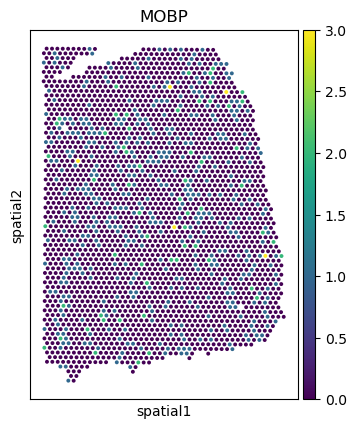

In [10]:
sc.pl.spatial(simulated_adata,color = "MOBP",spot_size = 100)

In [5]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.stats import poisson, nbinom, bernoulli
from scipy.spatial.distance import pdist, squareform
from typing import Dict, List, Tuple
from tqdm import tqdm
from numba import jit
from concurrent.futures import ThreadPoolExecutor
import logging

logging.basicConfig(level=logging.INFO)

class OptimizedSpatialExpressionSimulator:
    def __init__(
        self,
        coords: np.ndarray,
        model_params: Dict,
        target_moran: pd.DataFrame,
        gene_pairs: List[Tuple[str, str]],
        target_correlations: np.ndarray,
    ):
        self.coords = coords
        self.n_spots = len(coords)
        self.genes = list(target_moran.index)
        
        # 重新组织model_params确保基因对应关系正确
        self.model_params = self._reorganize_model_params(model_params)
        
        self.target_moran = target_moran
        self.gene_pairs = gene_pairs
        self.target_correlations = target_correlations
        self.weights = self._calculate_weights().astype(np.float64)
        self.moran_weights = self._calculate_moran_weights().astype(np.float64)
        
        self.sorted_genes = self.target_moran.sort_values('moran_I', ascending=False).index.tolist()
        
        # 创建基因对的字典
        self.gene_pair_dict = {}
        for (g1, g2), corr in zip(gene_pairs, target_correlations):
            if g1 in self.genes and g2 in self.genes:
                self.gene_pair_dict.setdefault(g1, {})[g2] = corr
                self.gene_pair_dict.setdefault(g2, {})[g1] = corr

    def _reorganize_model_params(self, model_params: Dict) -> Dict:
        """重新组织model_params，确保与目标基因完全对应"""
        logging.info("Starting model parameters reorganization...")
        
        # 打印详细的调试信息
        logging.info(f"Target genes sample: {self.genes[:5]}")
        logging.info(f"Model params keys: {model_params.keys()}")
        logging.info(f"Model params genes sample: {list(model_params['genes'])[:5]}")
        
        # 创建原始基因到索引的映射
        orig_gene_idx = {}
        if isinstance(model_params['genes'], dict):
            # 如果genes是字典形式，直接使用
            orig_gene_idx = model_params.values()
            logging.info("Using dictionary mapping from model_params['genes']")
        else:
            # 如果genes是列表形式，创建映射
            orig_gene_idx = {str(gene): i for i, gene in enumerate(model_params['genes'])}
            logging.info("Created mapping from list of genes")
        
        new_params = {
            'genes': self.genes,
            'marginal_param1': [],
            'model_selected': [],
            'min_nonzero_num': model_params['min_nonzero_num'],
            'n_cell': model_params['n_cell'],
            'n_read': model_params['n_read']
        }
        
        found_genes = 0
        not_found_genes = []
        
        # 为每个目标基因获取对应的参数
        for gene in self.genes:
            gene_str = str(gene)  # 确保基因名称是字符串类型
            if gene_str in orig_gene_idx:
                idx = orig_gene_idx[gene_str]
                new_params['marginal_param1'].append(model_params['marginal_param1'][idx])
                new_params['model_selected'].append(model_params['model_selected'][idx])
                found_genes += 1
            else:
                not_found_genes.append(gene_str)
                new_params['marginal_param1'].append([0, 1, 1])
                new_params['model_selected'].append('Poisson')
        
        # 打印详细的匹配统计
        logging.info(f"Total target genes: {len(self.genes)}")
        logging.info(f"Total genes in model_params: {len(orig_gene_idx)}")
        logging.info(f"Successfully matched genes: {found_genes}")
        logging.info(f"Genes not found: {len(not_found_genes)}")
        
        if not_found_genes:
            logging.warning(f"Sample of genes not found: {not_found_genes[:5]}")
            
        # 验证参数列表长度
        logging.info(f"Length of marginal_param1: {len(new_params['marginal_param1'])}")
        logging.info(f"Length of model_selected: {len(new_params['model_selected'])}")
        
        return new_params
    def _calculate_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        sigma = np.median(distances)
        weights = np.exp(-distances**2 / (2 * sigma**2))
        np.fill_diagonal(weights, 0)
        return weights / weights.sum(axis=1, keepdims=True)

    def _calculate_moran_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        weights = 1 / (distances + 1e-8)
        np.fill_diagonal(weights, 0)
        return weights / np.sum(weights)

    def _generate_expression(self, gene_idx: int) -> np.ndarray:
        param = self.model_params['marginal_param1'][gene_idx]
        model_type = self.model_params['model_selected'][gene_idx]
        
        try:
            if model_type == 'Poisson':
                expr = poisson.rvs(param[2], size=self.n_spots)
            
            elif model_type == 'NB':
                r_param = param[1]
                if np.isinf(r_param):
                    expr = poisson.rvs(param[2], size=self.n_spots)
                else:
                    p_param = r_param / (r_param + param[2])
                    r_param = np.maximum(r_param, 1e-8)
                    p_param = np.clip(p_param, 1e-8, 1 - 1e-8)
                    expr = nbinom.rvs(r_param, p_param, size=self.n_spots)
            
            elif model_type == 'ZIP':
                expr = poisson.rvs(param[2], size=self.n_spots) * (1 - bernoulli.rvs(param[0], size=self.n_spots))
            
            elif model_type == 'ZINB':
                r_param = param[1]
                p_param = r_param / (r_param + param[2])
                r_param = np.maximum(r_param, 1e-8)
                p_param = np.clip(p_param, 1e-8, 1 - 1e-8)
                expr = nbinom.rvs(r_param, p_param, size=self.n_spots) * (1 - bernoulli.rvs(param[0], size=self.n_spots))
            
            else:
                raise ValueError(f"Unknown model type: {model_type}")
            
            return expr
            
        except Exception as e:
            logging.error(f"Error generating expression for gene index {gene_idx}: {str(e)}")
            return poisson.rvs(1, size=self.n_spots)

    @staticmethod
    @jit(nopython=True)
    def _calculate_moran_i_fast(expr: np.ndarray, weights: np.ndarray) -> float:
        n = len(expr)
        z = expr - expr.mean()
        s0 = weights.sum()
        s2 = ((expr - expr.mean()) ** 2).sum()
        numerator = n * np.sum(weights * np.outer(z, z))
        denominator = s2 * s0
        return numerator / denominator if denominator != 0 else 0

    def _calculate_moran_i(self, expr: np.ndarray) -> float:
        return self._calculate_moran_i_fast(expr, self.moran_weights)

    @staticmethod
    @jit(nopython=True)
    def _calculate_spatial_correlation_fast(expr1: np.ndarray, expr2: np.ndarray, weights: np.ndarray) -> float:
        weighted_exp1 = np.dot(weights, expr1)
        weighted_exp2 = np.dot(weights, expr2)
        return np.corrcoef(weighted_exp1, weighted_exp2)[0, 1]

    def _optimize_gene_expression(self, gene: str, existing_expr: Dict[str, np.ndarray], related_genes: List[str]) -> np.ndarray:
        gene_idx = self.genes.index(gene)
        target_moran = float(self.target_moran.loc[gene, 'moran_I'])
        
        best_expr = None
        best_score = float('-inf')
        
        for _ in range(50):
            expr = self._generate_expression(gene_idx)
            moran_score = self._calculate_moran_i(expr)
            
            if np.isnan(moran_score):
                continue
                
            moran_diff = (moran_score - target_moran) ** 2
            
            corr_diff = 0
            if related_genes:
                valid_correlations = 0
                for related_gene in related_genes:
                    if related_gene in existing_expr and related_gene in self.gene_pair_dict.get(gene, {}):
                        target_corr = self.gene_pair_dict[gene][related_gene]
                        actual_corr = self._calculate_spatial_correlation_fast(
                            expr, existing_expr[related_gene], self.weights
                        )
                        if not np.isnan(actual_corr):
                            corr_diff += (actual_corr - target_corr) ** 2
                            valid_correlations += 1
                
                if valid_correlations > 0:
                    corr_diff /= valid_correlations
            
            score = -moran_diff - corr_diff
            
            if score > best_score and not np.isnan(score):
                best_score = score
                best_expr = expr.copy()
        
        return best_expr if best_expr is not None else np.zeros(self.n_spots)

    def simulate(self) -> ad.AnnData:
        simulated_expr = {}
        optimized_genes = []
        batch_size = 100  # 批处理大小
        
        for batch_start in tqdm(range(0, len(self.sorted_genes), batch_size), desc="Processing gene batches"):
            batch_genes = self.sorted_genes[batch_start:batch_start + batch_size]
            
            with ThreadPoolExecutor(max_workers=4) as executor:
                futures = {}
                for gene in batch_genes:
                    related_genes = [g for g in optimized_genes[-50:] if g in self.gene_pair_dict.get(gene, {})]
                    futures[gene] = executor.submit(
                        self._optimize_gene_expression,
                        gene,
                        simulated_expr,
                        related_genes
                    )
                
                for gene, future in futures.items():
                    try:
                        result = future.result()
                        if result is not None:
                            simulated_expr[gene] = result
                            optimized_genes.append(gene)
                    except Exception as e:
                        logging.error(f"Error processing gene {gene}: {str(e)}")
                        simulated_expr[gene] = np.zeros(self.n_spots)

        # 构建最终的表达矩阵
        expr_matrix = np.zeros((self.n_spots, len(self.genes)))
        for i, gene in enumerate(self.genes):
            if gene in simulated_expr:
                expr_matrix[:, i] = simulated_expr[gene]

        # 创建AnnData对象
        adata = ad.AnnData(
            X=expr_matrix,
            obs=pd.DataFrame(index=[f'spot_{i}' for i in range(self.n_spots)]),
            var=pd.DataFrame(index=self.genes),
            obsm={'spatial': self.coords}
        )
        
        return adata

In [ ]:

import numpy as np
import pandas as pd
import anndata as ad
from scipy.stats import poisson, nbinom, bernoulli
from scipy.spatial.distance import pdist, squareform
from typing import Dict, List, Tuple
from tqdm import tqdm
from numba import jit
from concurrent.futures import ThreadPoolExecutor
import logging

logging.basicConfig(level=logging.INFO)

@jit(nopython=True)
def _calculate_moran_i_fast(expr: np.ndarray, weights: np.ndarray) -> float:
    n = len(expr)
    z = expr - expr.mean()
    s0 = weights.sum()
    s2 = (z ** 2).sum()
    numerator = n * np.sum(weights * np.outer(z, z))
    denominator = s2 * s0
    return numerator / denominator if denominator != 0 else 0

@jit(nopython=True)
def _calculate_spatial_correlation_fast(expr1: np.ndarray, expr2: np.ndarray, weights: np.ndarray) -> float:
    weighted_exp1 = np.dot(weights, expr1)
    weighted_exp2 = np.dot(weights, expr2)
    return np.corrcoef(weighted_exp1, weighted_exp2)[0, 1]

class OptimizedSpatialExpressionSimulator:

    def __init__(
        self,
        coords: np.ndarray,
        model_params: Dict,
        target_moran: pd.DataFrame,
        gene_pairs: List[Tuple[str, str]],
        target_correlations: np.ndarray,
    ):
        self.coords = coords.astype(np.float64)
        self.n_spots = len(coords)
        self.genes = list(target_moran.index)
        self.model_params = self._reorganize_model_params(model_params)
        self.target_moran = target_moran
        self.gene_pairs = gene_pairs
        self.target_correlations = target_correlations.astype(np.float64)
        self.weights = self._calculate_weights()
        self.moran_weights = self._calculate_moran_weights()
        self.sorted_genes = self.target_moran.sort_values('moran_I', ascending=False).index.tolist()
        self.gene_corr_dict = self._create_gene_corr_dict()
        self.expr_cache = {}

    def _reorganize_model_params(self, model_params: Dict) -> Dict:
        gene_to_idx = {gene: idx for idx, gene in model_params['genes'].items()}
        return {
            'genes': self.genes,
            'marginal_param1': [model_params['marginal_param1'][gene_to_idx[g]] if g in gene_to_idx 
                              else [0, 1, 1] for g in self.genes],
            'model_selected': [model_params['model_selected'][gene_to_idx[g]] if g in gene_to_idx 
                             else 'Poisson' for g in self.genes],
            'min_nonzero_num': model_params['min_nonzero_num'],
            'n_cell': model_params['n_cell'],
            'n_read': model_params['n_read']
        }

    def _create_gene_corr_dict(self) -> Dict[str, List[Tuple[str, float]]]:
        gene_corr_dict = {gene: [] for gene in self.genes}
        for (g1, g2), corr in zip(self.gene_pairs, self.target_correlations):
            if g1 in self.genes and g2 in self.genes:
                gene_corr_dict[g1].append((g2, float(corr)))
                gene_corr_dict[g2].append((g1, float(corr)))
        return gene_corr_dict

    def _calculate_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        sigma = np.median(distances)
        weights = np.exp(-distances**2 / (2 * sigma**2))
        np.fill_diagonal(weights, 0)
        weights = weights / weights.sum(axis=1, keepdims=True)
        return weights.astype(np.float64)

    def _calculate_moran_weights(self) -> np.ndarray:
        distances = squareform(pdist(self.coords))
        weights = 1 / (distances + 1e-8)
        np.fill_diagonal(weights, 0)
        weights = weights / np.sum(weights)
        return weights.astype(np.float64)

    def _generate_expression(self, gene_idx: int) -> np.ndarray:
        if gene_idx in self.expr_cache:
            return self.expr_cache[gene_idx].copy()
        
        param = self.model_params['marginal_param1'][gene_idx]
        model_type = self.model_params['model_selected'][gene_idx]
        
        try:
            if model_type == 'Poisson':
                expr = poisson.rvs(param[2], size=self.n_spots)
            elif model_type == 'NB':
                r_param = param[1]
                if np.isinf(r_param):
                    expr = poisson.rvs(param[2], size=self.n_spots)
                else:
                    p_param = r_param / (r_param + param[2])
                    r_param = np.maximum(r_param, 1e-8)
                    p_param = np.clip(p_param, 1e-8, 1 - 1e-8)
                    expr = nbinom.rvs(r_param, p_param, size=self.n_spots)
            else:  # ZIP or ZINB
                base = poisson.rvs(param[2], size=self.n_spots) if model_type == 'ZIP' else \
                       nbinom.rvs(np.maximum(param[1], 1e-8),
                                np.clip(param[1]/(param[1]+param[2]), 1e-8, 1-1e-8),
                                size=self.n_spots)
                expr = base * (1 - bernoulli.rvs(param[0], size=self.n_spots))
            
            expr = expr.astype(np.float64)
            self.expr_cache[gene_idx] = expr
            return expr
        except Exception as e:
            logging.error(f"Error generating expression for gene {gene_idx}: {str(e)}")
            return np.ones(self.n_spots, dtype=np.float64)

    def _adaptive_genetic_algorithm(self, genes: List[str], gene_indices: List[int], existing_expr: Dict[str, np.ndarray],
                                      related_genes: Dict[str, List[str]]) -> Dict[str, np.ndarray]:
        population_size = 50
        num_generations = 30
        mutation_rate = 0.1

        population = [{gene: self._generate_expression(gene_idx) for gene, gene_idx in zip(genes, gene_indices)} for _ in range(population_size)]
        best_fitness = float('-inf')
        best_expr = None

        for _ in range(num_generations):
            with ThreadPoolExecutor() as executor:
                fitness_scores = list(executor.map(self._calculate_fitness, population, [genes]*population_size, [existing_expr]*population_size, [related_genes]*population_size))

            best_idx = np.argmax(fitness_scores)
            best_gen_fitness = fitness_scores[best_idx]

            if best_gen_fitness > best_fitness:
                best_fitness = best_gen_fitness
                best_expr = population[best_idx].copy()

            if best_fitness > -0.01:
                break

            # Selection
            fitness_scores = np.array(fitness_scores)
            probs = fitness_scores - fitness_scores.min() + 1e-6
            probs = probs / probs.sum()
            parents_idx = np.random.choice(len(population), size=population_size, p=probs)
            parents = [population[idx].copy() for idx in parents_idx]

            # Crossover and Mutation
            new_population = []
            for i in range(0, population_size, 2):
                if i + 1 < population_size:
                    child1 = {}
                    child2 = {}
                    for gene in genes:
                        c1, c2 = self._crossover(parents[i][gene], parents[i+1][gene])
                        child1[gene] = self._mutate(c1, mutation_rate)
                        child2[gene] = self._mutate(c2, mutation_rate)
                    new_population.extend([child1, child2])
                else:
                    mutated_individual = {}
                    for gene in genes:
                        mutated_individual[gene] = self._mutate(parents[i][gene].copy(), mutation_rate)
                    new_population.append(mutated_individual)
            population = new_population

        return best_expr if best_expr is not None else population[best_idx]

    def _calculate_fitness(self, individual: Dict[str, np.ndarray], genes: List[str],
                           existing_expr: Dict[str, np.ndarray], related_genes: Dict[str, List[str]]) -> float:
        moran_diff = 0
        corr_diff = 0

        for gene in genes:
            target_moran = float(self.target_moran.loc[gene, 'moran_I'])
            moran_score = _calculate_moran_i_fast(individual[gene], self.moran_weights)
            moran_diff += 10 * (moran_score - target_moran) ** 2  # Increased weight for Moran's I

            for related_gene in related_genes.get(gene, []):
                if related_gene in existing_expr:
                    target_corr = next((corr for g, corr in self.gene_corr_dict[gene] if g == related_gene), 0)
                    actual_corr = _calculate_spatial_correlation_fast(individual[gene], existing_expr[related_gene], self.weights)
                    if target_corr > 0.9 and actual_corr < 0.9:
                        corr_diff += (actual_corr - target_corr) ** 2  # Penalize if correlation drops below 0.9

        return -(moran_diff + corr_diff)

    def _crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        crossover_point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[:crossover_point:]])
        return child1, child2

    def _mutate(self, individual: np.ndarray, mutation_rate: float) -> np.ndarray:
        mutation_mask = np.random.random(individual.shape) < mutation_rate
        if mutation_mask.any():  # Only mutate if the mask is True somewhere
            mutation = np.random.poisson(1, size=individual.shape)
            individual[mutation_mask] += mutation[mutation_mask]
            individual[mutation_mask] -= np.random.poisson(1, size=np.sum(mutation_mask))
        return np.maximum(individual, 0)

    def simulate(self) -> ad.AnnData:
        simulated_expr = {}
        genes_to_simulate = self.sorted_genes

        chunk_size = 10  # Simulate genes in chunks
        for i in tqdm(range(0, len(genes_to_simulate), chunk_size), desc="Optimizing gene expressions"):
            genes_chunk = genes_to_simulate[i:i + chunk_size]
            gene_indices = [self.genes.index(gene) for gene in genes_chunk]
            related_genes = {gene: [g for g, _ in self.gene_corr_dict[gene] if g in simulated_expr] for gene in genes_chunk}

            # Heuristic initialization: prioritize high Moran's I and spatial co-occurrence
            initial_population = self._heuristic_initialization(genes_chunk, related_genes, simulated_expr)
            if initial_population: # Use the heuristic initialization if available
                population = initial_population
            else:
                population = [{gene: self._generate_expression(gene_idx) for gene, gene_idx in zip(genes_chunk, gene_indices)} for _ in range(50)]
            
            chunk_expr = self._adaptive_genetic_algorithm(genes_chunk, gene_indices, simulated_expr, related_genes)
            simulated_expr.update(chunk_expr)

        expr_matrix = np.zeros((self.n_spots, len(self.genes)), dtype=np.float64)
        for i, gene in enumerate(self.genes):
            expr_matrix[:, i] = simulated_expr[gene]

        return ad.AnnData(
            X=expr_matrix,
            obs=pd.DataFrame(index=[f'spot_{i}' for i in range(self.n_spots)]),
            var=pd.DataFrame(index=self.genes),
            obsm={'spatial': self.coords}
        )

    def _heuristic_initialization(self, genes, related_genes, existing_expr):
        initial_population = []
        for _ in range(50):  # Create an initial population of 50 individuals
            individual = {}
            for gene in genes:
                gene_idx = self.genes.index(gene)
                expr = self._generate_expression(gene_idx)

                if related_genes.get(gene):
                    # Adjust expression based on related genes already simulated
                    related_expr = np.array([existing_expr[rg] for rg in related_genes[gene] if rg in existing_expr])
                    if related_expr.size > 0:
                        expr = expr * (1 + np.mean(related_expr, axis=0) / np.maximum(np.mean(expr), 1e-8))  # Scale by related gene expression
                        expr = np.maximum(0, expr)  # Ensure non-negative expression

                individual[gene] = expr
            initial_population.append(individual)
        return initial_population

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from tqdm.auto import tqdm
from sklearn.metrics import pairwise_distances
import logging


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(raw_adata_path, target_moran_path, gene_pairs_path, model_params_path):
    logging.info("Loading data...")
    raw_adata = sc.read_h5ad(raw_adata_path)
    
    target_moran = pd.read_csv(target_moran_path, index_col=0)
    target_moran.columns = ['moran_I']
    
    gene_pairs_df = pd.read_csv(gene_pairs_path)
    gene_pairs = list(zip(gene_pairs_df['gene1'], gene_pairs_df['gene2']))
    target_correlations = gene_pairs_df['correlation'].values

    with open(model_params_path, "rb") as f:
        model_params = pickle.load(f)

    return raw_adata, target_moran, gene_pairs, target_correlations, model_params

def calculate_morans_i(expr, weights):
    expr = expr - expr.mean()
    s0 = weights.sum()
    s2 = (expr ** 2).sum()
    numerator = np.sum(weights * np.outer(expr, expr))
    morans_i = (len(expr) * numerator) / (s2 * s0)
    return morans_i

def calculate_spatial_correlation(gene_pair, adata, dist_matrix):
    gene1, gene2 = gene_pair
    expr1 = adata[:, gene1].X.flatten()
    expr2 = adata[:, gene2].X.flatten()
    weighted_expr1 = np.dot(dist_matrix, expr1)
    weighted_expr2 = np.dot(dist_matrix, expr2)
    return pearsonr(weighted_expr1, weighted_expr2)[0]

def validate_results(simulated_adata, target_moran, gene_pairs, target_correlations, coords):
    logging.info("Validating results...")
    
    # Calculate weights for Moran's I
    distances = squareform(pdist(coords))
    sigma = np.median(distances)
    weights = np.exp(-distances**2 / (2 * sigma**2))
    np.fill_diagonal(weights, 0)
    weights /= weights.sum(axis=1, keepdims=True)

    # Calculate Moran's I for simulated data
    morans_i_results = []
    for gene in tqdm(simulated_adata.var_names, desc="Calculating Moran's I"):
        expr = simulated_adata[:, gene].X.flatten()
        morans_i = calculate_morans_i(expr, weights)
        morans_i_results.append(morans_i)

    morans_i_df = pd.DataFrame({
        'gene': simulated_adata.var_names,
        'simulated_moran_I': morans_i_results
    }).set_index('gene')
    
    comparison_df = morans_i_df.join(target_moran)
    
    # Calculate spatial correlations
    dist_matrix = np.exp(-pairwise_distances(coords) ** 2 / (2 * sigma ** 2))
    np.fill_diagonal(dist_matrix, 0)

    spatial_corr_results = []
    for gene_pair in tqdm(gene_pairs, desc="Calculating spatial gene pair correlations"):
        correlation = calculate_spatial_correlation(gene_pair, simulated_adata, dist_matrix)
        spatial_corr_results.append(correlation)

    spatial_corr_df = pd.DataFrame({
        'gene1': [gp[0] for gp in gene_pairs],
        'gene2': [gp[1] for gp in gene_pairs],
        'simulated_correlation': spatial_corr_results,
        'target_correlation': target_correlations
    })

    return comparison_df, spatial_corr_df

def visualize_results(comparison_df, spatial_corr_df):
    logging.info("Visualizing results...")
    
    # Moran's I comparison
    plt.figure(figsize=(10, 6))
    plt.scatter(comparison_df['moran_I'], comparison_df['simulated_moran_I'], alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Target Moran\'s I')
    plt.ylabel('Simulated Moran\'s I')
    plt.title('Comparison of Target vs Simulated Moran\'s I')
    plt.savefig('morans_i_comparison.png')
    plt.close()

    # Spatial correlation comparison
    plt.figure(figsize=(10, 6))
    plt.scatter(spatial_corr_df['target_correlation'], spatial_corr_df['simulated_correlation'], alpha=0.5)
    plt.plot([-1, 1], [-1, 1], 'r--')
    plt.xlabel('Target Spatial Correlation')
    plt.ylabel('Simulated Spatial Correlation')
    plt.title('Comparison of Target vs Simulated Spatial Correlations')
    plt.savefig('spatial_correlation_comparison.png')
    plt.close()

raw_adata, target_moran, gene_pairs, target_correlations, model_params = load_data(
    "/mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad",  # Replace with your actual path
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/moran_indices.csv",  # Replace with your actual path
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/spatial_correlations.csv",  # Replace with your actual path
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/151675_model.pkl"  # Replace with your actual path
)

coords = raw_adata.obsm['spatial']

# Create simulator instance
simulator = OptimizedSpatialExpressionSimulator(
    coords=coords,
    model_params=model_params,
    target_moran=target_moran,
    gene_pairs=gene_pairs,
    target_correlations=target_correlations
)

# Run simulation
logging.info("Starting simulation...")
simulated_adata = simulator.simulate()
logging.info("Simulation completed.")

# Save simulated data (optional)
simulated_adata.write_h5ad("path/to/save/simulated_data.h5ad") # Replace with desired save path

# Basic validation and information
logging.info(f"Number of spots: {simulated_adata.n_obs}")
logging.info(f"Number of genes: {simulated_adata.n_vars}")
logging.info(f"Shape of expression matrix: {simulated_adata.X.shape}")

# Validate and visualize results
comparison_df, spatial_corr_df = validate_results(simulated_adata, target_moran, gene_pairs, target_correlations, coords)

logging.info("\nMoran's I comparison (simulated vs target):")
print(comparison_df.head())

visualize_results(comparison_df, spatial_corr_df)

# Example of accessing and using simulated data:
example_gene = simulated_adata.var_names[0]
expression_values = simulated_adata[:, example_gene].X
print(f"Expression values for gene {example_gene}:\n{expression_values}")


{0: 'NOC2L',
 1: 'KLHL17',
 2: 'HES4',
 3: 'ISG15',
 4: 'AGRN',
 5: 'C1orf159',
 6: 'SDF4',
 7: 'B3GALT6',
 8: 'UBE2J2',
 9: 'SCNN1D',
 10: 'ACAP3',
 11: 'PUSL1',
 12: 'INTS11',
 13: 'CPTP',
 14: 'DVL1',
 15: 'MXRA8',
 16: 'AURKAIP1',
 17: 'CCNL2',
 18: 'MRPL20',
 19: 'ANKRD65',
 20: 'VWA1',
 21: 'ATAD3B',
 22: 'ATAD3A',
 23: 'SSU72',
 24: 'FNDC10',
 25: 'AL691432.2',
 26: 'MIB2',
 27: 'CDK11B',
 28: 'SLC35E2B',
 29: 'SLC35E2A',
 30: 'NADK',
 31: 'GNB1',
 32: 'GABRD',
 33: 'PRKCZ',
 34: 'FAAP20',
 35: 'SKI',
 36: 'RER1',
 37: 'PEX10',
 38: 'PLCH2',
 39: 'PANK4',
 40: 'TNFRSF14',
 41: 'FAM213B',
 42: 'LINC00982',
 43: 'TPRG1L',
 44: 'WRAP73',
 45: 'LRRC47',
 46: 'CEP104',
 47: 'C1orf174',
 48: 'AJAP1',
 49: 'NPHP4',
 50: 'KCNAB2',
 51: 'CHD5',
 52: 'RPL22',
 53: 'ICMT',
 54: 'GPR153',
 55: 'ACOT7',
 56: 'TNFRSF25',
 57: 'PLEKHG5',
 58: 'NOL9',
 59: 'ZBTB48',
 60: 'KLHL21',
 61: 'PHF13',
 62: 'THAP3',
 63: 'DNAJC11',
 64: 'CAMTA1',
 65: 'VAMP3',
 66: 'PER3',
 67: 'PARK7',
 68: 'ERRFI1',


In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import pickle
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from tqdm.auto import tqdm
from sklearn.metrics import pairwise_distances

# Function to calculate Moran's I for a single gene expression vector
def calculate_morans_i(expr, coords, weights):
    expr = expr - expr.mean()
    s0 = weights.sum()
    s2 = (expr ** 2).sum()
    numerator = np.sum(weights * np.outer(expr, expr))
    morans_i = (len(expr) * numerator) / (s2 * s0)
    return morans_i

# Function to calculate correlation for gene pairs in simulated data
def calculate_spatial_correlation(gene_pair, adata, dist_matrix):
    gene1, gene2 = gene_pair
    expr1 = adata[:, gene1].X.flatten()
    expr2 = adata[:, gene2].X.flatten()
    weighted_expr1 = np.dot(dist_matrix, expr1)
    weighted_expr2 = np.dot(dist_matrix, expr2)
    return pearsonr(weighted_expr1, weighted_expr2)[0]

if __name__ == "__main__":
    raw_adata = sc.read_h5ad("/mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad")
    
    # 读取目标 Moran's I 值
    target_moran = pd.read_csv("/mnt/volume1/2023SRTP/library/cyr/simulation_results/moran_indices.csv", index_col=0, names=['gene', 'moran_I'])
    target_moran = target_moran[1:]
    
    # 读取基因对和目标相关性
    gene_pairs_df = pd.read_csv("/mnt/volume1/2023SRTP/library/cyr/simulation_results/spatial_correlations.csv")
    gene_pairs = list(zip(gene_pairs_df['gene1'], gene_pairs_df['gene2']))
    target_correlations = gene_pairs_df['correlation'].values

    # 读取模型参数
    with open("/mnt/volume1/2023SRTP/library/cyr/simulation_results/151675_model.pkl", "rb") as f:
        model_params = pickle.load(f)

    # 获取坐标
    coords = raw_adata.obsm['spatial']

    # 创建模拟器实例
    simulator = OptimizedSpatialExpressionSimulator(
        coords=coords,
        model_params=model_params,
        target_moran=target_moran,
        gene_pairs=gene_pairs,
        target_correlations=target_correlations
    )

    # 运行模拟
    simulated_adata = simulator.simulate()

    print("Simulation completed. Results saved to simulated_data.h5ad")

    # 可以添加一些基本的验证步骤
    print(f"Number of spots: {simulated_adata.n_obs}")
    print(f"Number of genes: {simulated_adata.n_vars}")
    print(f"Shape of expression matrix: {simulated_adata.X.shape}")


    # 计算模拟数据中的 Moran's I 值并与目标值比较
    print("\nChecking spatial autocorrelation (Moran's I) preservation...")

    # 距离矩阵（用于计算权重矩阵）
    distances = squareform(pdist(coords))
    sigma = np.median(distances)
    weights = np.exp(-distances**2 / (2 * sigma**2))
    np.fill_diagonal(weights, 0)
    weights /= weights.sum(axis=1, keepdims=True)

    morans_i_results = []
    for gene in tqdm(simulated_adata.var_names, desc="Calculating Moran's I"):
        expr = simulated_adata[:, gene].X.toarray().flatten()
        morans_i = calculate_morans_i(expr, coords, weights)
        morans_i_results.append(morans_i)

    # 将结果转换为 DataFrame 方便比较
    morans_i_df = pd.DataFrame({
        'gene': simulated_adata.var_names,
        'simulated_moran_I': morans_i_results
    })
    morans_i_df = morans_i_df.set_index('gene')
    comparison_df = morans_i_df.join(target_moran)

    # 打印比较结果
    print("\nMoran's I comparison (simulated vs target):")
    print(comparison_df.head())

    # 计算基因对之间的空间相关性并与目标相关性进行比较
    print("\nChecking spatial correlation preservation...")

    # 计算基因对之间的距离加权相关性
    dist_matrix = np.exp(-pairwise_distances(coords) ** 2 / (2 * sigma ** 2))
    np.fill_diagonal(dist_matrix, 0)

    spatial_corr_results = []
    for gene_pair in tqdm(gene_pairs, desc="Calculating spatial gene pair correlations"):
        correlation = calculate_spatial_correlation(gene_pair, simulated_adata, dist_matrix)
        spatial_corr_results.append(correlation)

    # 将结果转换为 DataFrame 方便比较
    spatial_corr_df = pd.DataFrame({
        'gene1': [gp[0] for gp in gene_pairs],
        'gene2': [gp[1] for gp in gene_pairs],
        'simulated_correlation': spatial_corr_results,
        'target_correlation': target_correlations
    })

    # 打印比较结果
    print("\nSpatial correlation comparison (simulated vs target):")
    print(spatial_corr_df.head())